In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
import numpy as np
import network_dataloader as ndl

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


## Get pretrained model

In [2]:
net = models.vgg16(pretrained=True, progress=True).to(device=device)

## Modify the last layer to output the same as input

In [3]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
net.classifier[6] = Identity()

## Get dataset

In [4]:
batchSize = 56
input_size = 224
# Load Data
data_transforms = {
        'train': transforms.Compose([
                ndl.Rescale(input_size),
                ndl.ToTensor()]), 
        'test': transforms.Compose([
                ndl.Rescale(input_size),
                ndl.ToTensor()])
        }

print("Initializing Datasets and Dataloaders...")

# Create training and testing datasets
image_datasets = {x: ndl.TopoplotLoader('images', x, data_transforms[x]) for x in ['train', 'test']}

# Create training and testing dataloaders
dataloaders_dict = {'train': Data.DataLoader(image_datasets['train'], batch_size=batchSize, shuffle=True, num_workers=4),
                    'test':  Data.DataLoader(image_datasets['test'], batch_size=batchSize, shuffle=False, num_workers=4)}

Initializing Datasets and Dataloaders...
> Found 56 images...
> Found 7 images...


## Extract features by VGG16 

In [5]:
net.eval() # Disable batchnorm, dropout

# Training data
for samples in dataloaders_dict['train']:
    imgs = samples['image'].to(device=device)
    labels = samples['label'].to(device=device)
    
    with torch.no_grad():
        X_train = net(imgs).cpu().numpy()
    Y_train = labels.cpu().numpy()
    
print('X_train shape : ', X_train.shape)
print('Y_train shape : ', Y_train.shape)
    
# Testing data
for samples in dataloaders_dict['test']:
    imgs = samples['image'].to(device=device)
    labels = samples['label'].to(device=device)
    
    with torch.no_grad():
        X_test = net(imgs).cpu().numpy()
    Y_test = labels.cpu().numpy()
    
print('X_test shape : ', X_test.shape)
print('Y_test shape : ', Y_test.shape)
    


X_train shape :  (56, 4096)
Y_train shape :  (56,)
X_test shape :  (7, 4096)
Y_test shape :  (7,)


## Apply PCA to reduct dimension

In [6]:
pca = PCA(n_components=10)
pca.fit(X_train)

X_train_PCA = pca.transform(X_train)
X_test_PCA = pca.transform(X_test)

print('X_train_PCA shape : ', X_train_PCA.shape)
print('X_test_PCA shape : ', X_test_PCA.shape)

X_train_PCA shape :  (56, 10)
X_test_PCA shape :  (7, 10)


## Regression to predict solution time

In [13]:
clf = linear_model.LinearRegression()
clf.fit(X_train_PCA, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
A = np.arange(5)
np.sum(A**2)**(0.5)

5.477225575051661

Average difference of training data:  13.442337036132812


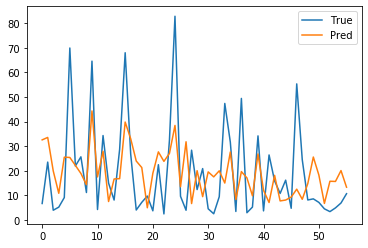

In [30]:
num_train = len(Y_train)
pred_train = clf.predict(X_train_PCA)
plt.plot(range(num_train), Y_train)
plt.plot(range(num_train), pred_train)
plt.legend(('True', 'Pred'))

MSE_train = 1/num_train * np.sum(np.abs(pred_train-Y_train))
print('Average difference of training data: ', MSE_train)

Average difference of testing data:  11.762938363211495


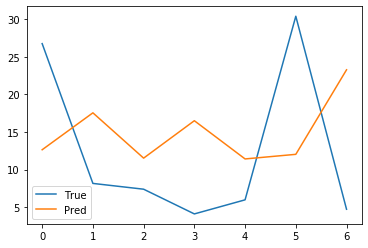

In [31]:
num_test = len(Y_test)
pred_test = clf.predict(X_test_PCA)
plt.plot(range(len(Y_test)), Y_test)
plt.plot(range(len(Y_test)), pred_test)
plt.legend(('True', 'Pred'))

MSE_test = 1/num_test * np.sum(np.abs(pred_test-Y_test))
print('Average difference of testing data: ', MSE_test)